# Is this a cat or a keyboard?

Run the below in the venv to make sure everything is installed beforehand

`pip install -Uqq fastai 'duckduckgo_search>=6.2'`

`pip install -U fastcore`

## Setup

In [ ]:
import socket,warnings
import os
import time, json
from duckduckgo_search import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.vision.all import *
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Collect Images

First we download an image of a cat and see how it looks

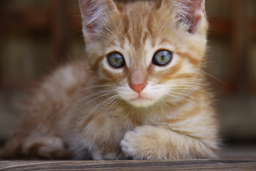

In [10]:
# use duckduckgo_search to grab images
def search_images(keyword, max_images=200):
    return L(DDGS().images(keyword, max_results=max_images)).itemgot('image')

# grab 1 cat pic
urls = search_images('cat', max_images=1)
dest = 'cat.jpg'
download_url(urls[0], dest, show_progress=False)
cat_img = Image.open(dest)
cat_img.to_thumb(256,256)

Next let's download an image of a keyboard too

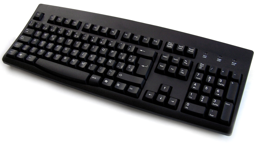

In [11]:
# grab 1 keyboard pic
download_url(search_images('keyboard', max_images=1)[0], 'keyboard.jpg', show_progress=False)
key_img = Image.open('keyboard.jpg').to_thumb(256,256)
key_img.to_thumb(256,256)

Now let's download a bunch more pictures of cats and keyboards. These will be saved to their own seperate folders in this directory. This might take a sec...

In [12]:
searches = 'cat','keyboard'
path = Path('cat_or_keyboard')

# download
for i in searches:
    dest = (path/i)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{i} photo'))
    time.sleep(5)
    resize_images(path/i, max_size=400, dest=path/i)

/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/

## Train the model

Check if all the images downloaded properly. Then we get rid of any bad downloads so they don't mess with our model training

In [13]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/

46

Now to train the model we use DataLoaders. This will use a training set and a validation set. 

Remember the validation set is never used during training. It is only used for eval after each epoch.

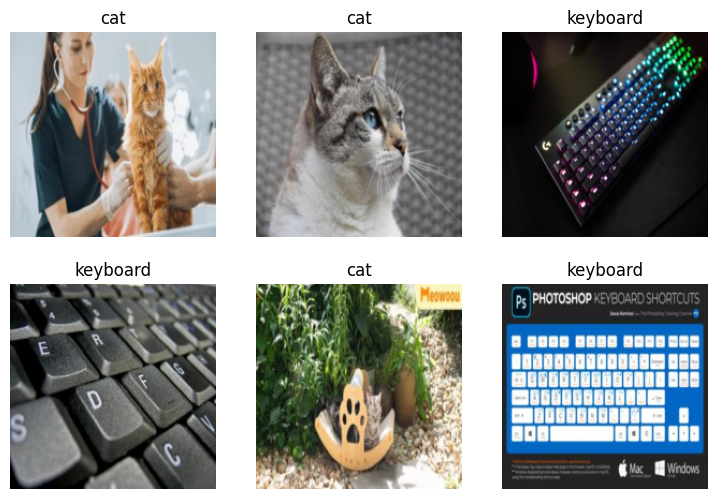

In [14]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(192, method='squish')]
).dataloaders(path, bs=32)

# peek at some images
dls.show_batch(max_n=6)

### DataBlock cheat code

`blocks = (ImageBlock, CategoryBlock),`

The model input will be images and we want categories for our output ("cat" and "keyboard")

`get_items = get_image_files,`

This will get all of the image files in whatever we set as `path`.

`splitter = RandomSplitter(valid_pct=0.2, seed=42),`

Now we split 20% of our data into the validation set.

`get_y = parent_label,`

Set the name of the parent of each file ("cat" or "keyboard")

`item_tfms=[Resize(192, method='squish')]`

Squish each image down to 192 x 192 px.


**And now we actually train...**

In [15]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

# train up to 20 epochs. stop early if no longer improving
learn.fine_tune(
    20, 
    cbs=EarlyStoppingCallback(monitor='valid_loss', patience=3)  # wait at least 3 epochs
)

epoch,train_loss,valid_loss,error_rate,time
0,0.183519,0.041170,0.008511,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.015802,0.047167,0.012766,00:04
1,0.011241,0.056709,0.010638,00:04
2,0.010376,0.040413,0.008511,00:04
3,0.009421,0.005631,0.002128,00:03
4,0.016587,0.012664,0.002128,00:03
5,0.014225,0.005712,0.002128,00:03
6,0.030497,0.043410,0.006383,00:04


No improvement since epoch 3: early stopping


## Lets try it out

Now we can use our model to check if that cat we downloaded earlier is actually a cat...

This is a: cat
with probability: 0.999988


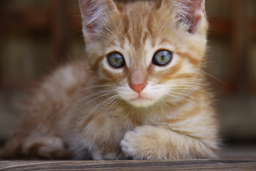

In [16]:
# predict if cat or keyboard with a probability
guess, _, prob = learn.predict(PILImage.create('cat.jpg'))
print(f"This is a: {guess}")
print(f"with probability: {prob[0]:.6f}")

cat_img.to_thumb(256,256)   # show starting cat

Or a keyboard...

This is a: keyboard
with probability: 1.000000


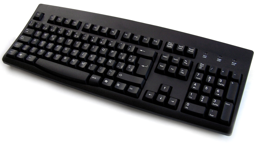

In [17]:
# predict if cat or keyboard with a probability
guess, _, prob = learn.predict(PILImage.create('keyboard.jpg'))
print(f"This is a: {guess}")
print(f"with probability: {prob[1]:.6f}")

key_img.to_thumb(256,256)   # show starting keboard

Or run this cell to try an image saved at `test.jpg`

This is a: cat
with probability: 1.000000


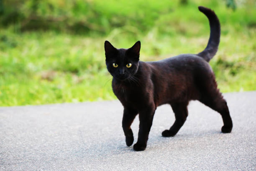

In [18]:
test_file = 'test.jpg'
guess, _, prob = learn.predict(PILImage.create(test_file))
print(f"This is a: {guess}")
print(f"with probability: {max(prob):.6f}")

# show image
test_img = Image.open(test_file)
test_img.to_thumb(256,256)

## Model analysis

That was pretty simple, so now lets do a bit of analysis on how our model actually performs.

In [21]:
preds, y_true = learn.get_preds(dl=dls.valid)
y_pred = preds.argmax(dim=1)

# generate classification report and convert to dataframe
report = classification_report(y_true, y_pred, target_names=['cat', 'keyboard'], output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report = df_report.round(3)


print(df_report[['precision', 'recall', 'f1-score']].iloc[:-3])
print(f"\nOverall Accuracy: {df_report.loc['accuracy', 'f1-score']:.1%}")

          precision  recall  f1-score
cat           1.000   0.989     0.994
keyboard      0.985   1.000     0.993

Overall Accuracy: 99.4%


Now lets see how confident our model was at making these decisions. We'll start by plotting a chart showing how many images were classified at varying levels of confidence using our model.

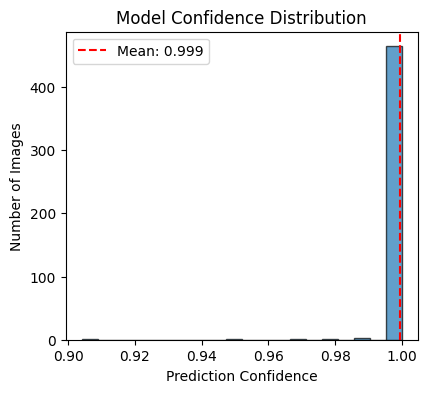

In [52]:
preds_np = preds.numpy()
confidences = preds_np.max(axis=1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(confidences, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(confidences.mean(), color='red', linestyle='--', label=f'Mean: {confidences.mean():.3f}')
plt.xlabel('Prediction Confidence')
plt.ylabel('Number of Images')
plt.title('Model Confidence Distribution')
plt.legend()
plt.show()

Next, lets a chart showing the confidence scores given when the model was **correct**, and the confidence scores when the model was **wrong**. 

Remember, the boxplot's whiskers show the maximum and minimum values for the confidence levels. The top and bottom of the box correspond to the 75th and 25th percentile. The center corresponds to the median of the confidence levels.

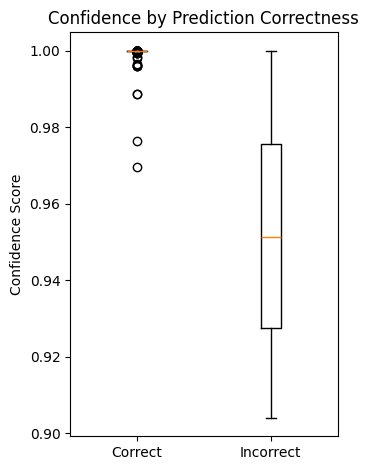

In [53]:
plt.subplot(1, 2, 2)
errors = y_pred != y_true
error_confidences = confidences[errors]
correct_confidences = confidences[~errors]

# create boxplot
plt.boxplot([correct_confidences, error_confidences], tick_labels=['Correct', 'Incorrect'])
plt.ylabel('Confidence Score')
plt.title('Confidence by Prediction Correctness')
plt.tight_layout()
plt.show()

### So what does this all actually mean?

Let's pretend we're running a company that offers a service to help users discern whether the picture they uploaded is of a cat or of a keyboard. Based off of our training and test data, we can get some key metrics for our customers and for our own insights. Let's calculate the average error rate of the model.

In [54]:
# calculate the metrics
error_rate = errors.sum() / len(errors)
avg_confidence = confidences.mean()
low_confidence_threshold = 0.8
low_confidence_preds = (confidences < low_confidence_threshold).sum()

# print out stats for our work
print(f"- Error Rate: {error_rate:.2%}")
print(f"  So our model misclassifies around {error_rate*100:.0f} out of 100 images\n")
print(f"- Average Confidence: {avg_confidence:.2%}")
print(f"  Model is generally {'confident' if avg_confidence > 0.85 else 'uncertain'} in predictions\n")
print(f"- Low Confidence Predictions: {low_confidence_preds} ({low_confidence_preds/len(confidences):.2%})")
print(f"  Due to low confidence, we might need employees to manually review {low_confidence_preds} images.")

- Error Rate: 0.64%
  So our model misclassifies around 1 out of 100 images

- Average Confidence: 99.95%
  Model is generally confident in predictions

- Low Confidence Predictions: 0 (0.00%)
  Due to low confidence, we might need employees to manually review 0 images.


We can also display a confusion matrix to give us a detailed breakdown into how our model actually classified everything.

**Quick confusion matrix cheat sheet**:

|                     | Predicted Positive  | Predicted Negative  |
| ------------------- | ------------------- | ------------------- |
| **Actual Positive** | True Positive (TP)  | False Negative (FN) |
| **Actual Negative** | False Positive (FP) | True Negative (TN)  |


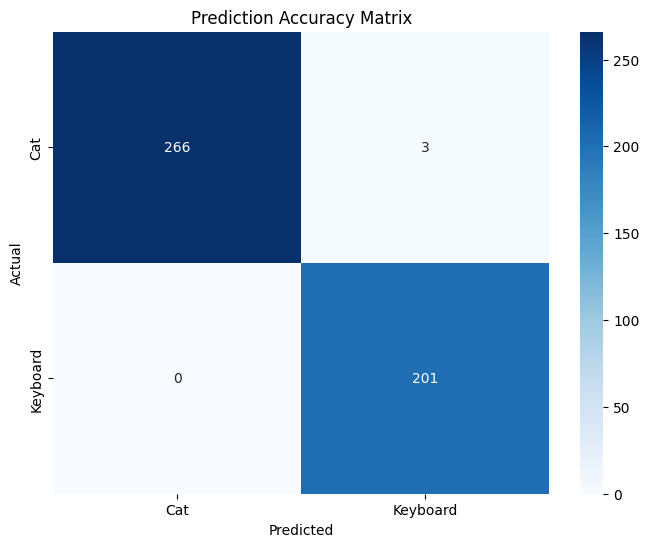

- 3 cats misclassified as keyboards
- 0 keyboards misclassified as cats
- Model tends to over-predict keyboards.


In [64]:
cmatrix = confusion_matrix(y_true, y_pred)

# display the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Keyboard'], yticklabels=['Cat', 'Keyboard'])
plt.title('Prediction Accuracy Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# interpret the results
false_positives = cmatrix[0, 1]  # cats predicted as keyboards
false_negatives = cmatrix[1, 0]  # keyboards predicted as cats
print(f"- {false_positives} cats misclassified as keyboards")
print(f"- {false_negatives} keyboards misclassified as cats")

# what is the model overpredicting
if false_positives > false_negatives:
    print("- Model tends to over-predict keyboards.")
else:
    print("- Model tends to over-predict cats.")

Now finally lets get some actual insights for our "Cat vs. Keyboard" business so we can make some good decisions about the future of the company.

### Scenario

Assume our business employs "Cat vs. Keyboard Specialists" to make executive decisions on low-confidence predictions. Lets assume it takes on average **3 seconds** for one of these specialists to correctly classify an image. Let's say that our business gets around **10000** images sent in each day. These hypothetical employees are paid an hourly wage of **$18.00/hr**.

In [69]:
# assumptions
wage_per_hour = 18.00
sec_per_class = 3
img_per_day = 10000

# calculations
review_fraction = low_confidence_preds / len(confidences)
images_needing_review = review_fraction * img_per_day
images_handled_by_ai = img_per_day - images_needing_review
time_saved_hours = images_handled_by_ai * sec_per_class / 3600
daily_cost_savings = time_saved_hours * wage_per_hour

# analysis prinout
print("If this classifier automated 10000 images each day:")
print(f"- Accuracy: {(1 - error_rate):.1%}")
print(f"- Images needing human review: {images_needing_review:.0f}")
print(f"- Time saved: ~{time_saved_hours:.1f} hours/day")
print(f"- Labor cost saved: ~${daily_cost_savings:,.2f} per day")
print("  (assuming 3 seconds per manual classification at $18/hr)")

If this classifier automated 10000 images each day:
- Accuracy: 99.4%
- Images needing human review: 0
- Time saved: ~8.3 hours/day
- Labor cost saved: ~$150.00 per day
  (assuming 3 seconds per manual classification at $18/hr)


Depending on what the model is over-predicting, we can gather more training data (images) less-predicted category and try this again. Since cats and keyboards come in a lot of different colours and in a lot of different settings, more diverse data could help us get even fewer errors.

### END